# Versicolor の がく片と幅の関係性を示すパラメータをベイズ推論

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
from pandas import infer_freq
from sympy import print_tree
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df_iris = sns.load_dataset('iris')  # Dataset
display(df_iris['species'].value_counts())
df_iris

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


sepal_length（がく片）と sepal_width（がくの幅）の散布図を描画

In [3]:
# 対象の品種、データの抽出
df_versicolor = df_iris.loc[df_iris['species'] == 'versicolor']  # 品種
sepal_lengths = df_versicolor.loc[:, 'sepal_length']  # がく片のデータ
sepal_widths  = df_versicolor.loc[:, 'sepal_width']   # がく幅のデータ

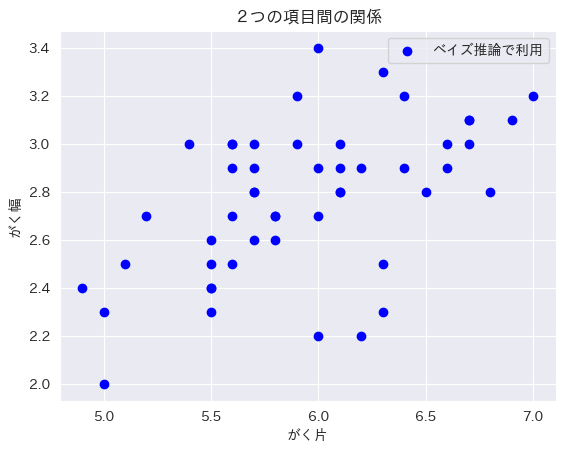

In [4]:
# 散布図の描画
plt.title('２つの項目間の関係')
plt.scatter(sepal_lengths, sepal_widths, label='ベイズ推論で利用', c='b', marker='o')
plt.legend()
plt.xlabel('がく片')
plt.ylabel('がく幅')
plt.show()

がく片とがく幅の間には仮説どおり、正の相関がありそう。

**関係性を１次関数で近似する**ことを、ベイズ推論してみる。

##### ２つの変数列の間で１次近似が可能であることを表現した数式

$Y_n = \alpha X_n + \beta + \epsilon_n$


In [12]:
# 確率モデル定義
model_linear_regression = pm.Model()  # インスタンス作成

with model_linear_regression:
    gradient = pm.Normal('gradient', mu=0, sigma=10.0)  # １次関数の傾き
    intercept = pm.Normal('intercept', mu=0, sigma=10.0)  # １次関数の切片

    mu = gradient * sepal_lengths + intercept  # 平均値 mu の計算
    standard_error = pm.HalfNormal('standard_error', sigma=1.0)  # 誤差の定義

    obs_sepal_with = pm.Normal('obs_sepal_with', mu=mu, sigma=standard_error, observed=sepal_widths)

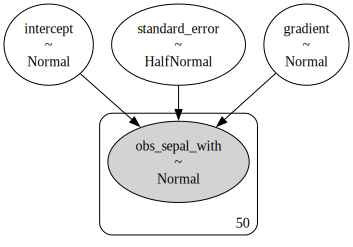

In [13]:
# 確率モデルを可視化
viz_model_Linear_regression = pm.model_to_graphviz(model_linear_regression)
viz_model_Linear_regression

`obs_sepal_with` と並んで重要な観測値の `obs_sepal_length` が、表現されていないため、改良を行う。

In [27]:
# 確率モデルの改良
model_linear_regression = pm.Model()

with model_linear_regression:
    data_sepal_length = pm.ConstantData('data_sepal_length', sepal_lengths)  # 定数データとして表現
    data_sepal_with   = pm.ConstantData('data_sepal_with',   sepal_widths)   # 定数データとして表現
    
    gradient  = pm.Normal('gradient',  mu=0.0, sigma=10.0)  # １次関数の傾き
    intercept = pm.Normal('intercept', mu=0.0, sigma=10.0)  # １次関数の切片
    
    mu = pm.Deterministic('mu', gradient * data_sepal_length + intercept)  # 平均値 mu を計算の途中経過の確率変数で表現
    standard_error = pm.HalfNormal('standard_error', sigma=1.0)  # 誤差を示す確率変数
    
    observations = pm.Normal('observations', mu=mu, sigma=standard_error, observed=data_sepal_with)

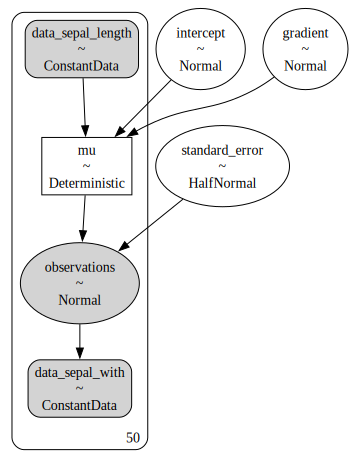

In [28]:
# 改良した確率モデルを可視化
viz_model_Linear_regression = pm.model_to_graphviz(model_linear_regression)
viz_model_Linear_regression

- ベイズ推論の対象となる確率変数は
    - `gradient`
    - `intercept`
    - `standar_error`
    の３つ（丸いアイコン）
- `data_sepal_length` と `data_sepal_width` は観測値に基づく定数データ（角が丸い四角形のアイコン）
- `mu` の計算には、
    - `data_sepal_length`
    - `gradient`
    - `intercept`
    が用いられている（四角アイコン）
- 下記の確率変数はそれぞれ要素数が 50 の配列
    - `data_sepal_length`
    - `data_sepal_width`
    - `mu`
    - `observations`
- `observations` の生成には
    - `mu`
    - `standard_error`
    がパラメータとして用いられている
- `observations` は、`data_sepal_width` を観測値として用いている。

In [29]:
# Sampling
with model_linear_regression:
    inference_linear_regression = pm.sample(chains=3, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [gradient, intercept, standard_error]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 225 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


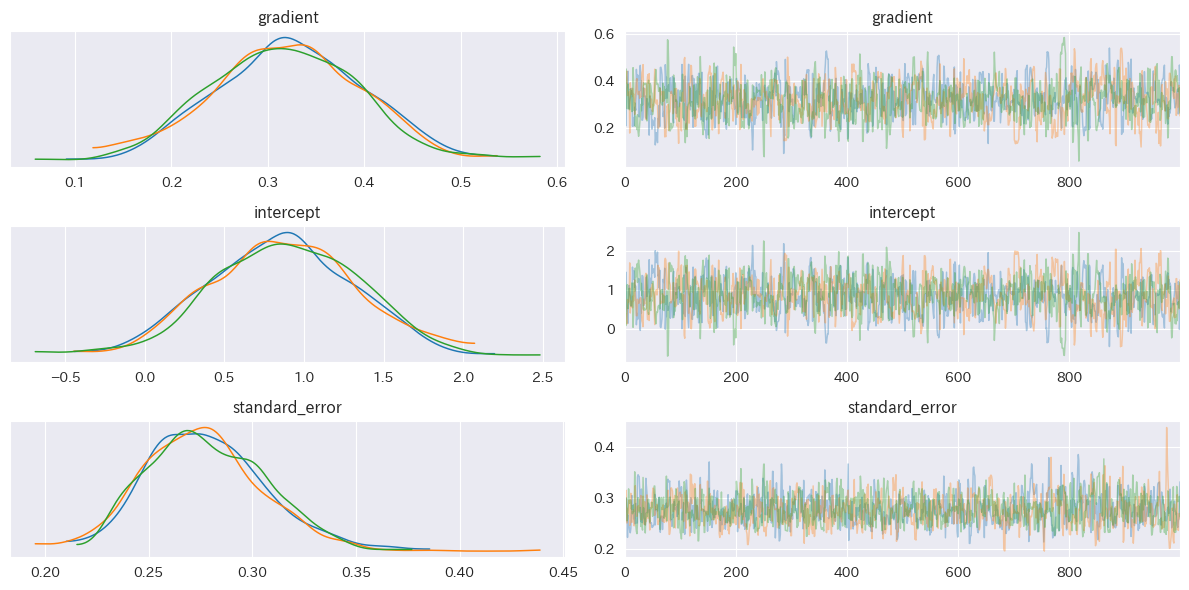

In [30]:
# 収束具体の確認
az.plot_trace(inference_linear_regression, compact=False, var_names=['gradient', 'intercept', 'standard_error'])
plt.tight_layout()
plt.show()

- 左グラフ: 各サンプル直系列の波形に違いはほぼなし。
- 右グラフ: 値の分布は均等にばらけている。

上記より、うまく収束できていそう、と判断。

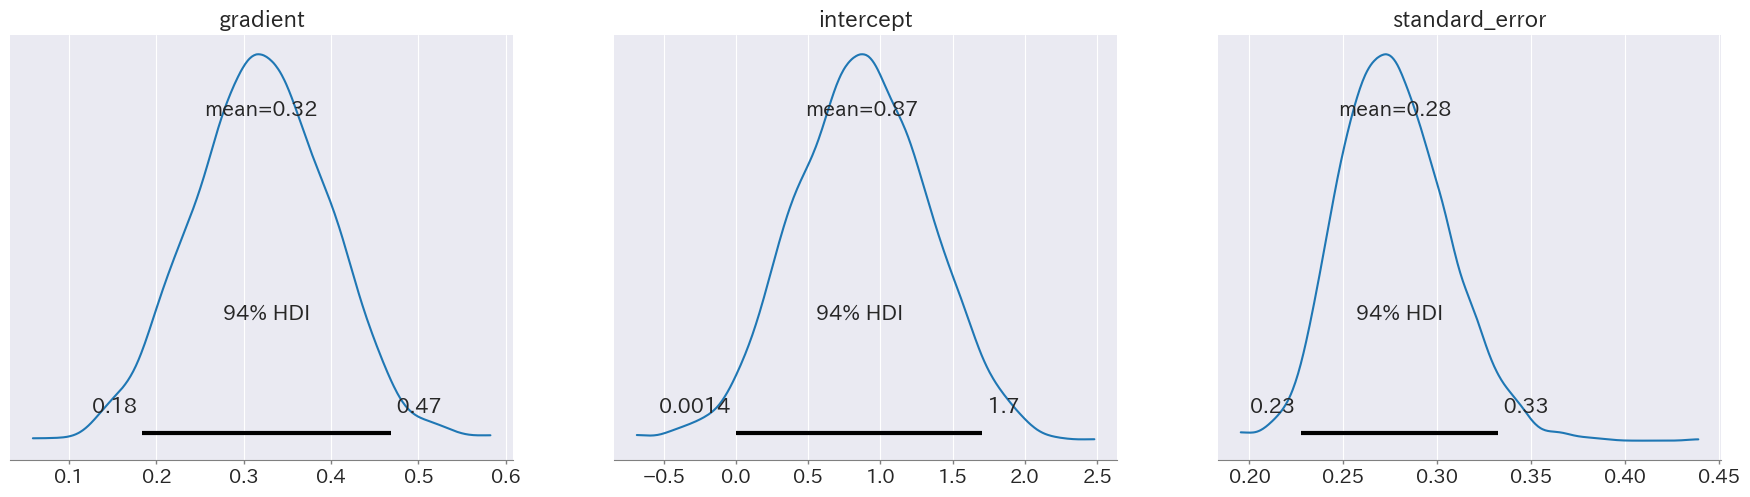

In [31]:
# 各サンプルの確率変数の分布を可視化
az.plot_posterior(inference_linear_regression, var_names=['gradient', 'intercept', 'standard_error'])
plt.show()

$$
Y_n = 0.32X_n + 0.87 + 0.28_n
$$

くらいの値になると推測される。

In [32]:
# 統計分析
az.summary(inference_linear_regression, var_names=['gradient', 'intercept', 'standard_error'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gradient,0.320,0.077,0.184,0.469,0.003,0.002,795.0,928.0,1.01
intercept,0.871,0.462,0.001,1.705,0.016,0.012,801.0,972.0,1.01
standard_error,0.277,0.029,0.227,0.332,0.001,0.001,1127.0,1462.0,1.00


- mcse_mean: 概ね 0.01 以下（※切片が 0.016)
- ess_bulk:  400以上
- r_hat:  1.01以下

でほぼ問題なく推論できていると判断される。